<a href="https://colab.research.google.com/github/kantasis/SalesAnalysis/blob/main/Sales_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Analysis Notebook



## 1. Load the data

In [2]:
# Parameters:
mountpoint_rpath = '/content/drive'
dataset_rfile = f'{mountpoint_rpath}/MyDrive/techpro/final/adjusted_retail_sales_data_v2.csv'

# Imports:
from google.colab import drive
drive.mount(mountpoint_rpath)

import pandas as pd
import matplotlib.pyplot as plt


Mounted at /content/drive


In [3]:
rawData_df = pd.read_csv(
  dataset_rfile,
  # dataset_url,
  # index_col=0,
)
N, M = rawData_df.shape

## 2. First Impressions

In [4]:
# Review the first lines of the data
rawData_df.head(10)

,SalesDate,ProductCategory,SalesAmount,CustomerAge,CustomerGender,CustomerLocation,ProductRatings
0,2023-10-15,Home Appliances,609,22,Male,USA,4
1,2023-09-16,Clothing,1367,22,Female,Australia,5
2,2022-09-06,Electronics,1736,22,Male,UK,2
3,2023-02-24,Female,1838,35,Clothing,India,2
4,2022-09-24,Home Appliances,1829,35,Male,UK,5
5,2023-08-15,Clothing,379,22,Male,Australia,3
6,2022-07-19,Clothing,1459,35,Male,USA,5
7,12-09-2023,Clothing,1656,35,Male,USA,3
8,2022-08-07,Electronics,366,35,Male,Canada,2
9,2023-12-04,Clothing,1875,35,Female,UK,10


In [5]:
# Review column-wise data
rawData_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SalesDate         1000 non-null   object
 1   ProductCategory   1000 non-null   object
 2   SalesAmount       1000 non-null   object
 3   CustomerAge       1000 non-null   int64 
 4   CustomerGender    1000 non-null   object
 5   CustomerLocation  998 non-null    object
 6   ProductRatings    1000 non-null   object
dtypes: int64(1), object(6)
memory usage: 54.8+ KB


Already we can see the following changes need to be made
- `SalesDate` column should be cast to date dtype
- Similarly `SalesAmount` and `CustomerAge` needs to be numeric, not object
- Column `ProductRatings` is apparently ordinal so we'd best convert it to numeric
- `ProductCategory`, `CustomerGender`, and `CustomerLocation` look like they are categorical so one-hot encoding sounds appropriate


## 3. Data cleaning and Preparation

In [6]:
# Let's create a 'workpiece' dataframe
df = rawData_df.copy()

Starting with the `SalesDate` column: we can see that most of the dates follow the '%Y-%m-%d' format. There are a few however that do not. Furthermore those dates are ambiguous as to their formatting.

Following the 'Garbage In - Garbage Out' concept, we opt to drop those rows.

In [7]:
# SalesDate

df['SalesDate'] = pd.to_datetime(
  df['SalesDate'],
  format='%Y-%m-%d',
  errors="coerce"
)

# Check to see if there are any dates that don't follow the format
validRows_mask = ~ df['SalesDate'].isna()
invalidRows_cnt = (~ validRows_mask).sum()
print(f"Dropping {invalidRows_cnt} rows with bad date format")

df = df[ validRows_mask ]

# Also let's use this column as the index of the dataframe
df = df.set_index('SalesDate')
df = df.sort_index()



Dropping 3 rows with bad date format


The `SalesAmount` should be straightforward. There are some rows that do not have a numeric representation which we will again drop

In [8]:
# SalesAmount
df['SalesAmount'] = pd.to_numeric(
  df['SalesAmount'],
  errors="coerce"
)

# Check if any rows have had invalid values
validRows_mask = ~ df['SalesAmount'].isna()
invalidRows_cnt = (~ validRows_mask).sum()
print(f"Dropping {invalidRows_cnt} rows with bad sales value")

# 6 more rows have invalid values for numeric conversion.
df = df[ validRows_mask ]

Dropping 6 rows with bad sales value


Checking the `CustomerAge` column

In [9]:
# CustomerAge
df['CustomerAge'] = pd.to_numeric(
  df['CustomerAge'],
  errors="coerce"
)
validRows_mask = ~ df['CustomerAge'].isna()
invalidRows_cnt = (~ validRows_mask).sum()
print(f"Found {invalidRows_cnt} rows with invalid age")

# Looks like there are no invalid ages
df['CustomerAge'].describe()


# However we can see that the range of the values is from 2 to 200 years

print(f"Values go from {df['CustomerAge'].min()} to {df['CustomerAge'].max()}")

# How many rows have odd ages?
underage_mask = df['CustomerAge'] < 18
print(f"{underage_mask.sum()} purchases refer to underage clients")
overage_mask = df['CustomerAge'] > 100
print(f"{overage_mask.sum()} purchases refer to overage clients")

# Looks like it's not that many
validRows_mask = (~ underage_mask) & (~ overage_mask)
df = df[validRows_mask]


Found 0 rows with invalid age
Values go from 2 to 200
1 purchases refer to underage clients
7 purchases refer to overage clients


In [10]:
# Let's also check the distribution of ages among the dataset
df['CustomerAge'].value_counts()

# Apparently the sales center around 2 ages: 22 and 35.
# There are 3 more sales at other ages but they don't seem to be unreasonable

22     505
35     475
100      1
95       1
20       1
Name: CustomerAge, dtype: int64

Checking the `ProductRatings` column

In [11]:
# ProductRatings
print(df['ProductRatings'].value_counts())

# From the looks of it, the ratings go from 1 to 5
# and there are 3 outlier values which are reasonably inferable
# invalidRows_mask = df['ProductRatings'].isin(['10','two','one'])

# Fix the invalid rows
df['ProductRatings'] = df['ProductRatings'].replace(['10','two','one'],[5,2,1])

# Cast the column to numeric
df['ProductRatings'] = pd.to_numeric(
  df['ProductRatings'],
  errors="coerce"
)


3      214
2      206
1      193
4      187
5      180
two      1
one      1
10       1
Name: ProductRatings, dtype: int64


<ipython-input-11-dbcb321d464b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ProductRatings'] = df['ProductRatings'].replace(['10','two','one'],[5,2,1])
<ipython-input-11-dbcb321d464b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ProductRatings'] = pd.to_numeric(


Check the `ProductCategory` column

In [12]:
# ProductCategory
print(df['ProductCategory'].value_counts())
# print(df['CustomerGender'].value_counts())

# There looks to be an invalid row so
invalidRows_mask = df['ProductCategory'] == 'Female'
print(df[invalidRows_mask])

# It looks like ProductCategory and CustomerGender got swapped
# Let's swap them back

temp = df.loc[invalidRows_mask,'ProductCategory']
df.loc[invalidRows_mask,'ProductCategory'] = df.loc[invalidRows_mask,'CustomerGender']
df.loc[invalidRows_mask,'CustomerGender'] = temp


Electronics        349
Clothing           322
Home Appliances    311
Female               1
Name: ProductCategory, dtype: int64
           ProductCategory  SalesAmount  CustomerAge CustomerGender  \
SalesDate                                                             
2023-02-24          Female       1838.0           35       Clothing   

           CustomerLocation  ProductRatings  
SalesDate                                    
2023-02-24            India               2  


Check the `CustomerGender` column



In [13]:
# CustomerGender
print(df['CustomerGender'].value_counts())

# We should have male-female and non-binary
# There are however several 'Unknown' and a 'did not answer' values
# We will consolidate them all as single 'Unknown' value
temp = df['CustomerGender'].map(lambda gender: 'Unknown' if gender=='Did not answer' else gender)
df['CustomerGender'] = temp



Male              479
Female            477
Unknown            22
Non-binary          4
Did not answer      1
Name: CustomerGender, dtype: int64


<ipython-input-13-e03fdd76d8aa>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CustomerGender'] = temp


Check the `CustomerLocation` column

In [14]:
# CustomerLocation
print(df['CustomerLocation'].value_counts())

# Those counts look right, nothing to do here

USA          203
UK           199
Canada       196
India        164
Australia    113
Japan        106
Name: CustomerLocation, dtype: int64


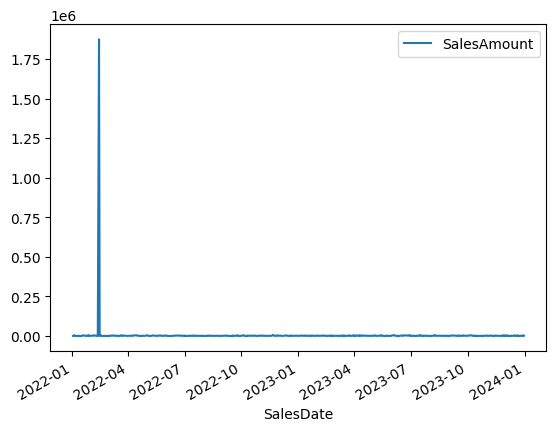

In [15]:
# Let's do a basic visualization of the data
data_ser = df.groupby(['SalesDate'])[['SalesAmount']].sum()
ax = data_ser.plot()

(0.0, 8010.294280811603)

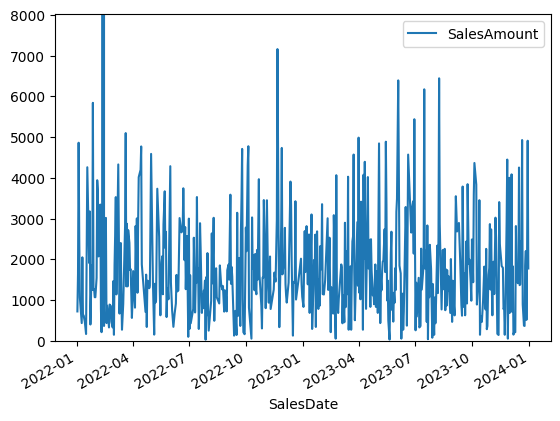

In [16]:
# There looks to be a huge outlier so let's try again:
ax = data_ser.plot()

# arbitrarily pick a max value to visualize
threshold_f = data_ser.std().values[0] / 10
ax.set_ylim(0, threshold_f)


In [17]:
# Print the row that is such an outlier
threshold_f = df['SalesAmount'].max() * 0.99
outlier_mask = df['SalesAmount'] > threshold_f
df[outlier_mask]

,ProductCategory,SalesAmount,CustomerAge,CustomerGender,CustomerLocation,ProductRatings
SalesDate,,,,,,
2022-02-13,Electronics,1875000.0,22,Male,Australia,2


In [18]:
# The outlier does not look to be like that because of data corruption.
# However, since its value is so out of the ordinary, we'd better exclude it from our analysis
df = df[~outlier_mask]

In [19]:
# Let's store the dataset to a different dataframe
dataset_df = df

Let's review the values in each column

In [20]:
# Briefly give some info on the cleaned data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 982 entries, 2022-01-02 to 2023-12-31
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ProductCategory   982 non-null    object 
 1   SalesAmount       982 non-null    float64
 2   CustomerAge       982 non-null    int64  
 3   CustomerGender    982 non-null    object 
 4   CustomerLocation  980 non-null    object 
 5   ProductRatings    982 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 53.7+ KB


In [21]:
# Some additional info on the numeric columns
df.describe()

,SalesAmount,CustomerAge,ProductRatings
count,982.000000,982.000000,982.000000
mean,981.268839,28.439919,2.954175
std,538.641279,7.207847,1.388367
min,22.000000,20.000000,1.000000
25%,512.500000,22.000000,2.000000
50%,987.000000,22.000000,3.000000
75%,1428.000000,35.000000,4.000000
max,1994.000000,100.000000,5.000000


In [22]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform ANOVA to test if there are any significant differences in average sales among product categories
f_statistic, p_value = f_oneway(
  df[df['ProductCategory'] == 'Clothing']['SalesAmount'],
  df[df['ProductCategory'] == 'Electronics']['SalesAmount'],
  df[df['ProductCategory'] == 'Home Appliances']['SalesAmount']
)

print("\nANOVA results for sales among product categories:")
print(f"F-statistic: {f_statistic}, p-value: {p_value}")

# Post-hoc tests (Tukey's HSD) to determine which pairs of categories have significantly different average sales
tukey_results = pairwise_tukeyhsd(df['SalesAmount'], df['ProductCategory'])
print("\nTukey's HSD post-hoc test results:")
print(tukey_results)



ANOVA results for sales among product categories:
F-statistic: 0.00714230031017688, p-value: 0.9928831970359074

Tukey's HSD post-hoc test results:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
   group1        group2     meandiff p-adj    lower    upper   reject
---------------------------------------------------------------------
   Clothing     Electronics   4.8253 0.9926  -92.9602 102.6108  False
   Clothing Home Appliances   1.4127 0.9994  -99.1339 101.9592  False
Electronics Home Appliances  -3.4127 0.9964 -102.1717  95.3464  False
---------------------------------------------------------------------


We've had to remove 18 records which represents 1.8% of the dataset's rows.
It would be safe to assume that no significant amount of information has been lost to the cleanup

## 4. Basic Visualization

In [23]:
dataset_df.columns

Index(['ProductCategory', 'SalesAmount', 'CustomerAge', 'CustomerGender',
       'CustomerLocation', 'ProductRatings'],
      dtype='object')

In [24]:

def plotColumn(df, column_name):
  labels_strLst=[]
  for column_val, groupedData_df in df.groupby(column_name):

    # Instead of daily data, aggregate the dates into months for better overview
    monthlyData_df = groupedData_df.resample('M')['SalesAmount'].sum()
    ax = monthlyData_df.plot(
      x='SalesDate',
      y='SalesAmount',
      # label=column_val,
      # ax=axes_lst[i]
      figsize=(16,4)
    )
    labels_strLst.append(column_val)

  ax.legend(labels_strLst)
  # ax.set_title(column_name)
  return ax



Electronics        348
Clothing           323
Home Appliances    311
Name: ProductCategory, dtype: int64

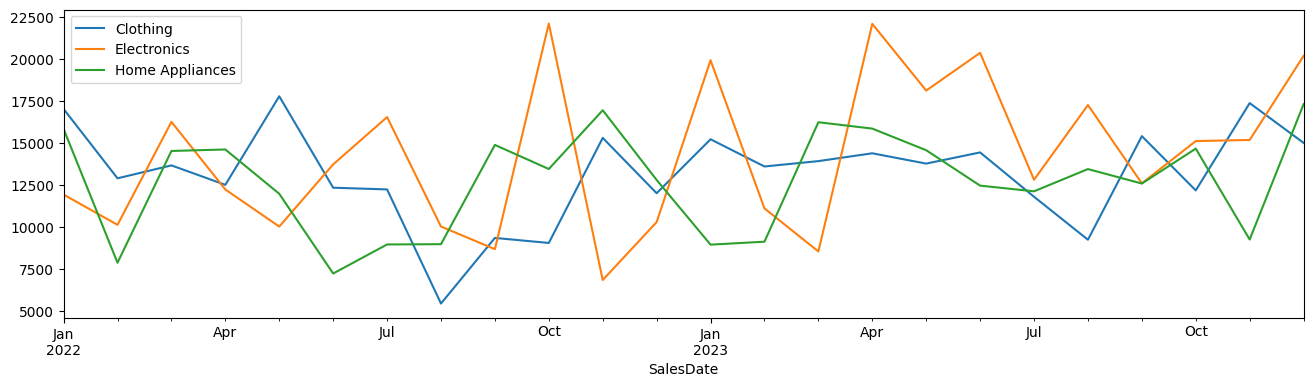

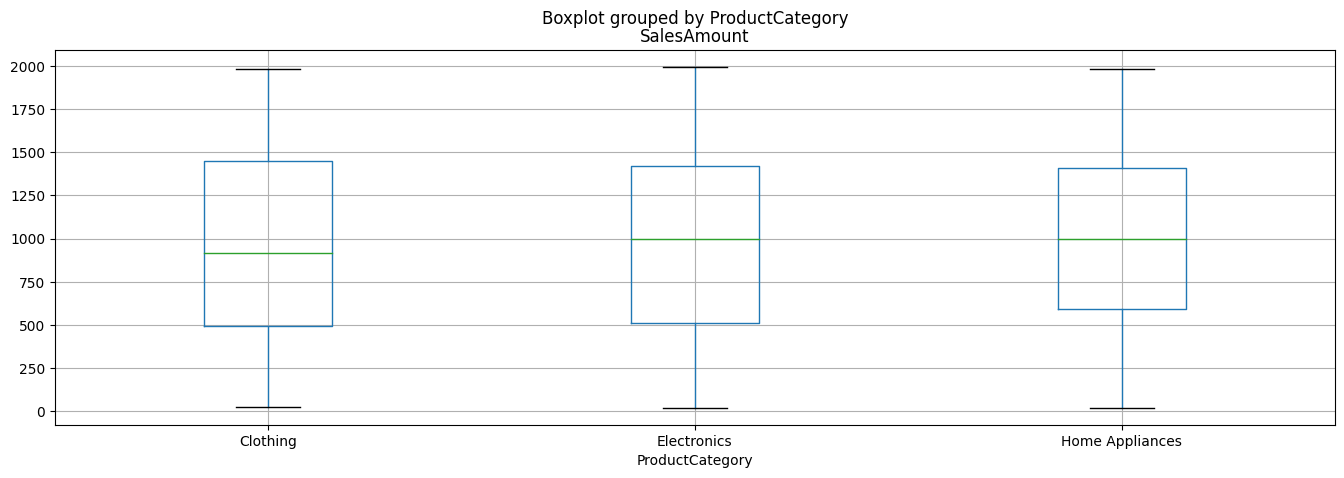

In [25]:
# Let's visualize ProductCategory
ax = plotColumn(df, 'ProductCategory')

# And let's review a boxplot of the values by
df.boxplot(column='SalesAmount', by='ProductCategory',figsize=(16,5))

df['ProductCategory'].value_counts()

As we can see from the time series, no clear trend (upward or downward) is evident.

The boxplot shows that the 3 categories have similar metrics (mean, variance, min, max)

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1400: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


20       1
22     504
35     475
95       1
100      1
Name: CustomerAge, dtype: int64

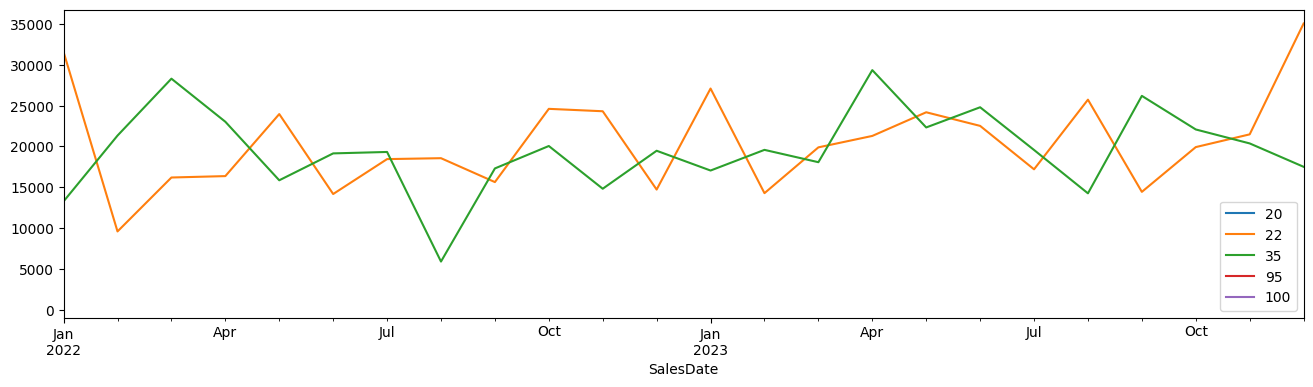

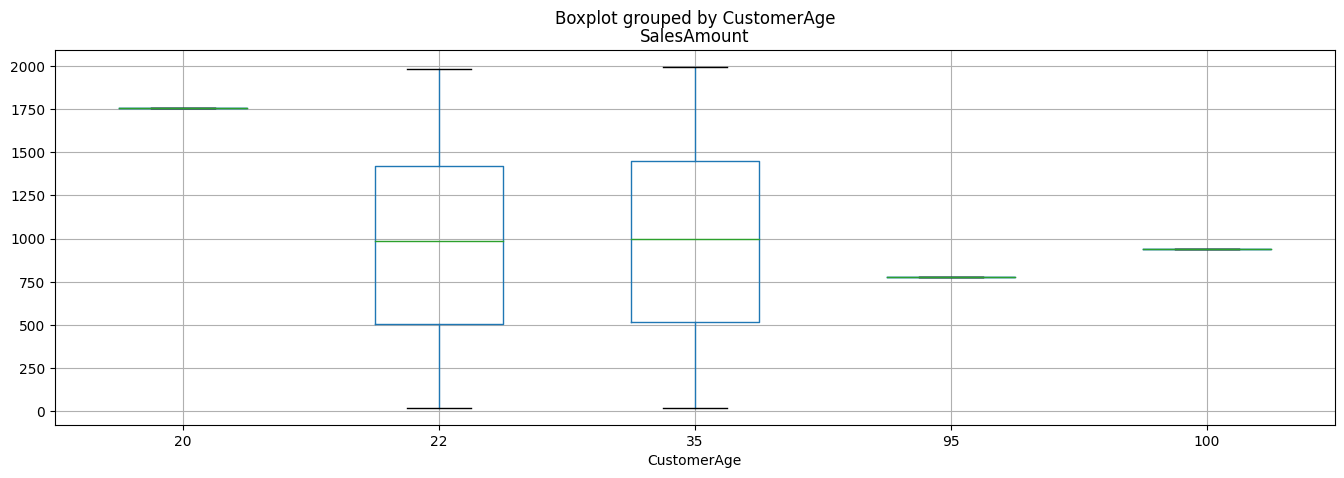

In [26]:
# CustomerAge Visualization
ax = plotColumn(df, 'CustomerAge')

# And let's review a boxplot of the values by
df.boxplot(column='SalesAmount', by='CustomerAge',figsize=(16,5))

df['CustomerAge'].value_counts().sort_index()

Like we've seen in the data cleaning step, there are 2 main ages in the dataset with similar spending habits (as per the boxplot). The other 3 ages other than being 'singles' do have somewhat different values but not overtly

The time series data again seems to show no trend or periodicity

Male          478
Female        477
Unknown        23
Non-binary      4
Name: CustomerGender, dtype: int64

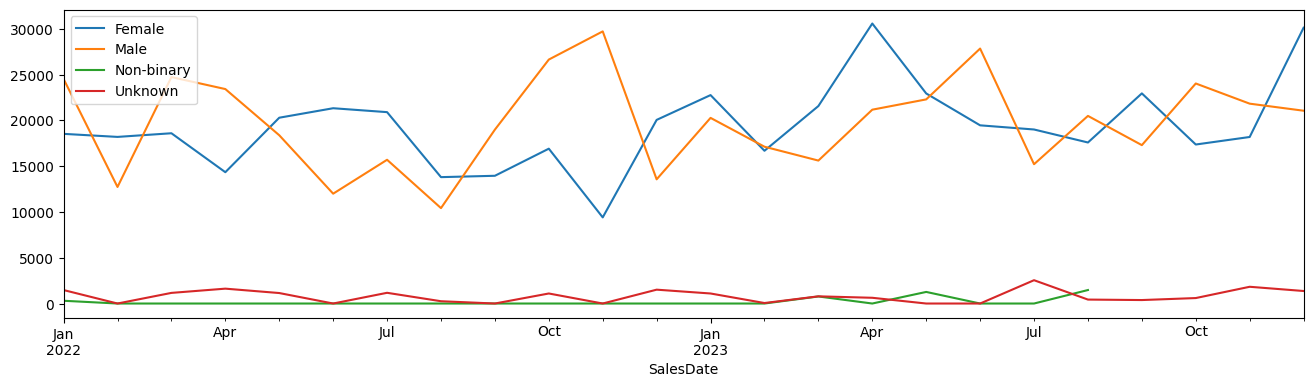

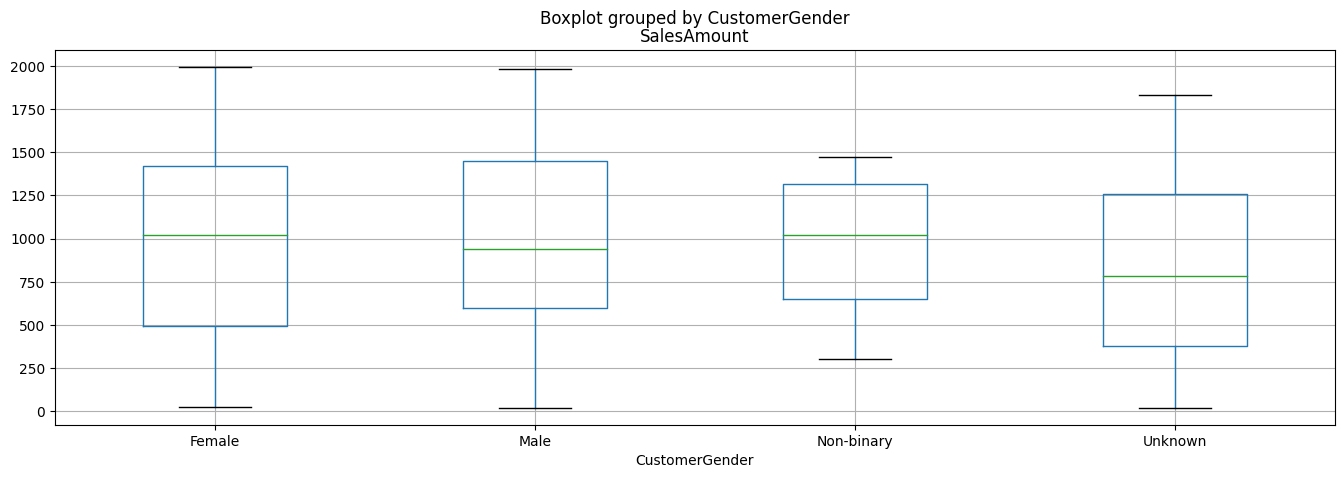

In [27]:
# CustomerAge Visualization
ax = plotColumn(df, 'CustomerGender')

# And let's review a boxplot of the values by
df.boxplot(column='SalesAmount', by='CustomerGender', figsize=(16,5))

df['CustomerGender'].value_counts()

USA          203
UK           199
Canada       196
India        164
Australia    112
Japan        106
Name: CustomerLocation, dtype: int64

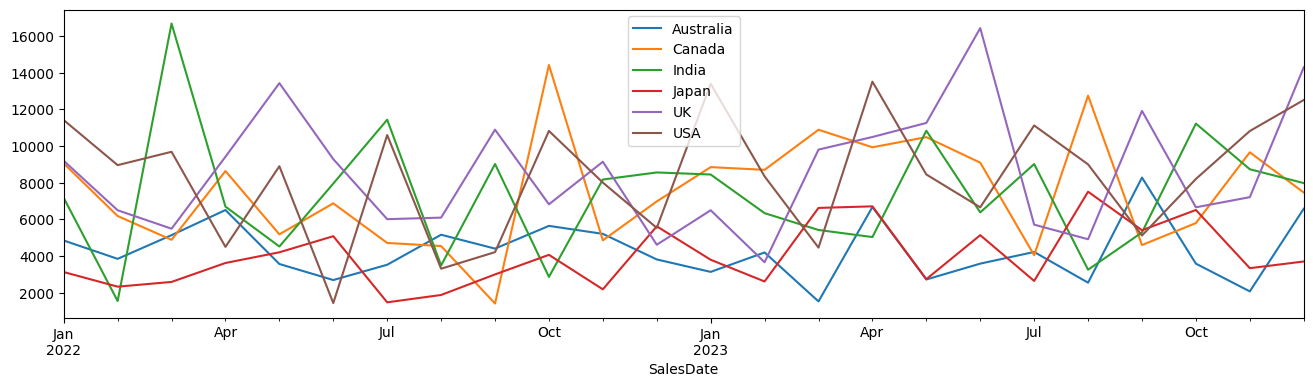

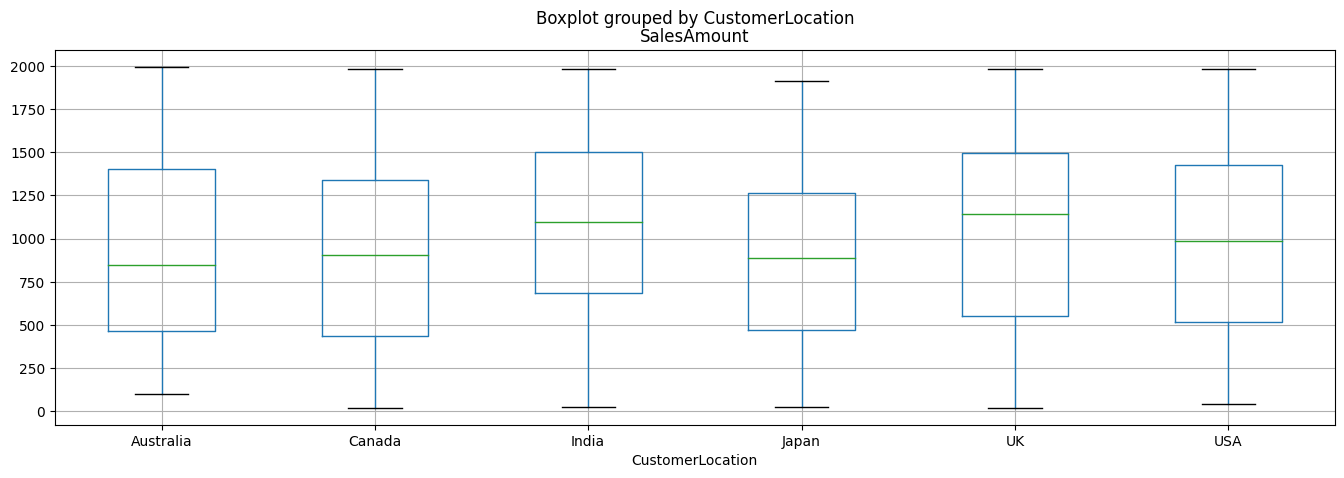

In [28]:
# CustomerLocation Visualization
ax = plotColumn(df, 'CustomerLocation')

# And let's review a boxplot of the values by
df.boxplot(column='SalesAmount', by='CustomerLocation', figsize=(16,5))

df['CustomerLocation'].value_counts()

What is interesting here is that even though the sales look to be similar for all locations, each country has vastly different populations and hence market size. It would be a safe interpretation that the market capitalization of Japan, with 35mil people is vastly greater than the market capitalization of India with a population of 1.4 billion

3    214
2    206
1    194
4    187
5    181
Name: ProductRatings, dtype: int64

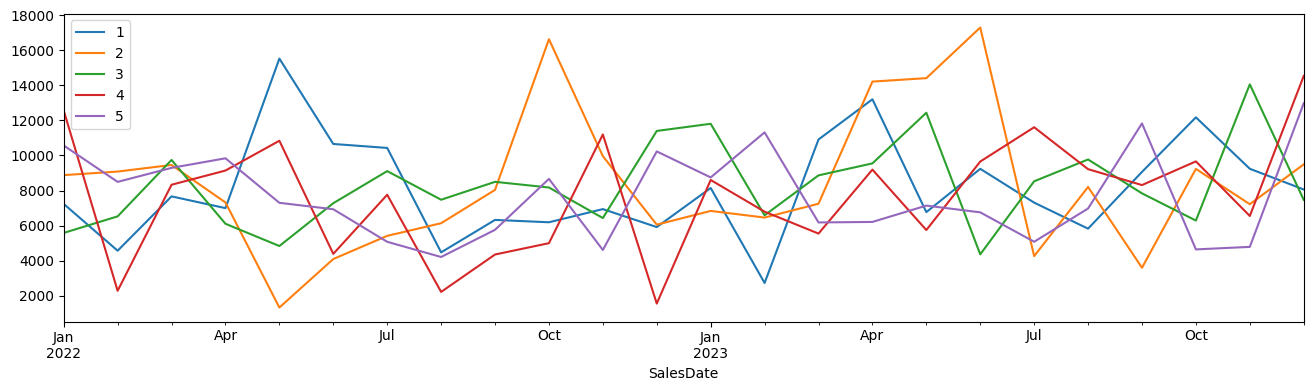

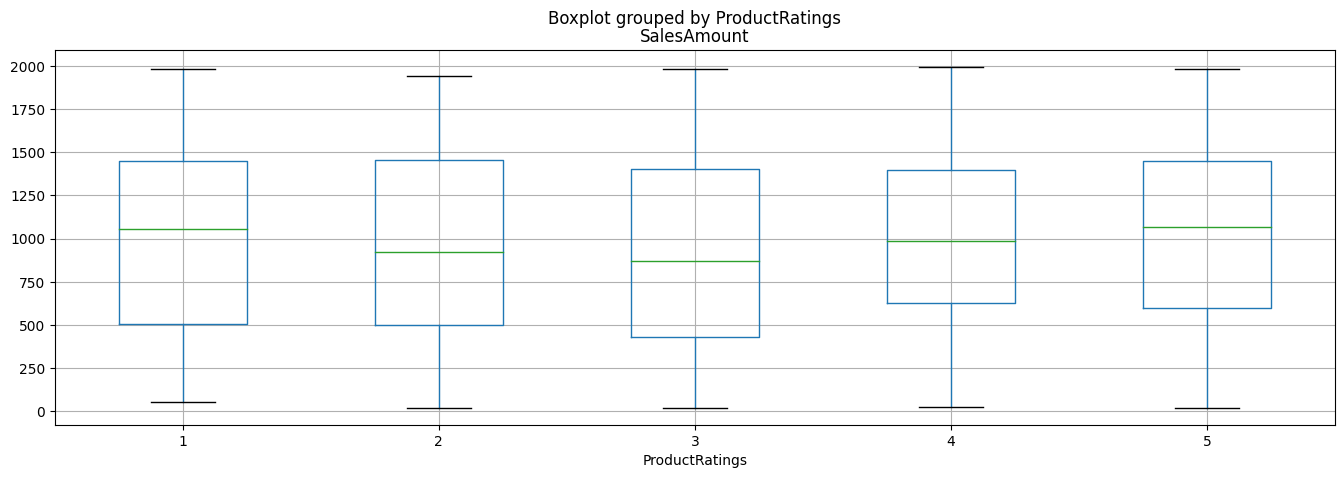

In [29]:
# ProductRatings Visualization
ax = plotColumn(df, 'ProductRatings')

# And let's review a boxplot of the values by
df.boxplot(column='SalesAmount', by='ProductRatings',figsize=(16,5))

df['ProductRatings'].value_counts()

What is interesting here is that sales amounts are quite similar across the entire spectrum of product ratings.

## 5. Clustering


In [30]:
df = dataset_df
df.columns

Index(['ProductCategory', 'SalesAmount', 'CustomerAge', 'CustomerGender',
       'CustomerLocation', 'ProductRatings'],
      dtype='object')

In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Let's begin with encoding the categorical columns

df = pd.get_dummies(
  df,
  columns=['ProductCategory', 'CustomerGender', 'CustomerLocation']
)

# From 6 columns we now have 17
print(len(df.columns))

16


In [32]:
# Since we've done one-hot encoding, let's check out the pairwise correlation
df.corr()


,SalesAmount,CustomerAge,ProductRatings,ProductCategory_Clothing,ProductCategory_Electronics,ProductCategory_Home Appliances,CustomerGender_Female,CustomerGender_Male,CustomerGender_Non-binary,CustomerGender_Unknown,CustomerLocation_Australia,CustomerLocation_Canada,CustomerLocation_India,CustomerLocation_Japan,CustomerLocation_UK,CustomerLocation_USA
SalesAmount,1.000000,0.004597,0.005876,-0.002805,0.003671,-0.000942,-0.009485,0.022878,-0.003388,-0.042838,-0.038143,-0.058004,0.077094,-0.049426,0.049736,-0.000671
CustomerAge,0.004597,1.000000,-0.035266,0.029757,-0.002096,-0.027899,0.011641,-0.006584,-0.028318,-0.004784,-0.025912,0.008055,-0.015973,0.030232,0.029347,-0.029776
ProductRatings,0.005876,-0.035266,1.000000,0.002814,-0.055313,0.054033,-0.022232,-0.007482,0.025155,0.087603,-0.004312,0.047703,-0.030466,-0.021621,-0.019864,0.016858
ProductCategory_Clothing,-0.002805,0.029757,0.002814,1.000000,-0.518685,-0.476626,0.035149,-0.040000,-0.010743,0.020563,0.007916,-0.013386,0.029388,0.007924,-0.034807,0.006579
ProductCategory_Electronics,0.003671,-0.002096,-0.055313,-0.518685,1.000000,-0.504387,-0.004424,0.019623,-0.047381,-0.030275,0.035561,-0.018420,0.005034,-0.010731,-0.002761,-0.004936
ProductCategory_Home Appliances,-0.000942,-0.027899,0.054033,-0.476626,-0.504387,1.000000,-0.030949,0.020221,0.059569,0.010362,-0.044559,0.032460,-0.034856,0.003032,0.037993,-0.001569
CustomerGender_Female,-0.009485,0.011641,-0.022232,0.035149,-0.004424,-0.030949,1.000000,-0.946482,-0.062155,-0.150511,-0.060272,-0.001049,0.040086,0.003357,0.016915,-0.003049
CustomerGender_Male,0.022878,-0.006584,-0.007482,-0.040000,0.019623,0.020221,-0.946482,1.000000,-0.062282,-0.150818,0.073597,0.003031,-0.037302,-0.003918,-0.019592,-0.009120
CustomerGender_Non-binary,-0.003388,-0.028318,0.025155,-0.010743,-0.047381,0.059569,-0.062155,-0.062282,1.000000,-0.009904,-0.022946,-0.031936,0.014230,-0.022246,0.047308,0.006835
CustomerGender_Unknown,-0.042838,-0.004784,0.087603,0.020563,-0.030275,0.010362,-0.150511,-0.150818,-0.009904,1.000000,-0.034383,0.006896,-0.015185,0.011225,-0.011070,0.037335


In [33]:
# Normalize the data using StandardScaler to make sure all features are on the same scale
scaler = StandardScaler()
data_np = scaler.fit_transform(df)


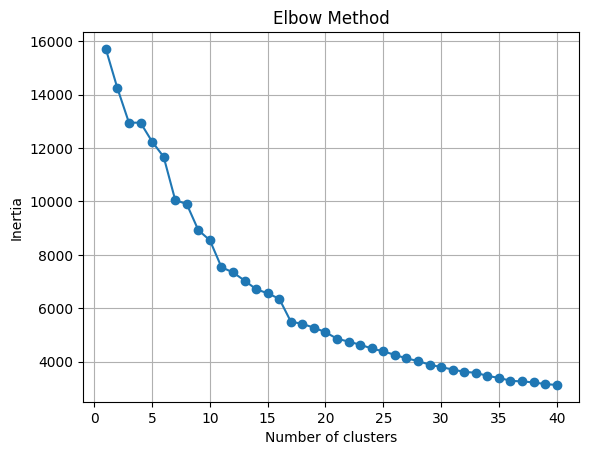

In [34]:
# Let's choose the number of clusters
wcss_fLst = []
kRange_intLst = range(1, 41)
for k in kRange_intLst:
    kmeans = KMeans(
      n_clusters=k,
      n_init="auto",
      random_state=42
    )
    kmeans.fit(data_np)
    # Within-Cluster Sum of Squares
    wcss_fLst.append(kmeans.inertia_)

plt.plot(kRange_intLst, wcss_fLst, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()


It looks like k=11 is a good cluster count for this case

In [35]:
kmeans = KMeans(
  n_clusters=11,
  n_init="auto",
  random_state=42
)
kmeans.fit(data_np)

# Get the (scaled) centroids
centroids_np = kmeans.cluster_centers_
# Unscale the centroids
centroids_np = scaler.inverse_transform(centroids_np)
# Get the centroids as a dataframe
centroids_df = pd.DataFrame(
  centroids_np,
  columns=df.columns
)

# Add the labels to the dataset
df['Cluster'] = pd.Series(kmeans.labels_, index = df.index)
# Also get the row count for each cluster
counts_ser = df['Cluster'].value_counts().sort_index()
centroids_df['Population'] = counts_ser

centroids_df
preprocessed_df = df

In [36]:
# Let's see some descriptive statistice of each cluster
extras_df = df.groupby(['Cluster']).agg(**{
  'Total Revenue':('SalesAmount', 'sum'),
  'Mean Age':('CustomerAge', 'mean'),
  'Mean Ratings':('ProductRatings', 'mean'),
  'Clothing %':('ProductCategory_Clothing', 'mean'),
  'Electronics %':('ProductCategory_Electronics', 'mean'),
  'Appliances %':('ProductCategory_Home Appliances', 'mean'),
  'Female %':('CustomerGender_Female', 'mean'),
  'Male %':('CustomerGender_Male', 'mean'),
  'Non-binary %':('CustomerGender_Non-binary', 'mean'),
  'Unknown Gender %':('CustomerGender_Unknown', 'mean'),
  'Australia %':('CustomerLocation_Australia', 'mean'),
  'Canada %':('CustomerLocation_Canada', 'mean'),
  'India %':('CustomerLocation_India', 'mean'),
  'Japan %':('CustomerLocation_Japan', 'mean'),
  'UK %':('CustomerLocation_UK', 'mean'),
  'USA %':('CustomerLocation_USA', 'mean'),
  'Count':('SalesAmount','count')
})

centroids_df[extras_df.columns] = extras_df

extras_df


,Total Revenue,Mean Age,Mean Ratings,Clothing %,Electronics %,Appliances %,Female %,Male %,Non-binary %,Unknown Gender %,Australia %,Canada %,India %,Japan %,UK %,USA %,Count
Cluster,,,,,,,,,,,,,,,,,
0,82751.0,27.909091,3.103896,0.000000,0.000000,1.000000,0.584416,0.415584,0.0,0.0,0.142857,0.000000,0.000000,0.000000,0.857143,0.000000,77
1,111986.0,27.837838,2.918919,0.000000,1.000000,0.000000,0.450450,0.549550,0.0,0.0,0.405405,0.585586,0.000000,0.000000,0.000000,0.000000,111
2,106758.0,28.500000,2.973214,0.410714,0.357143,0.232143,1.000000,0.000000,0.0,0.0,0.125000,0.000000,0.000000,0.000000,0.000000,0.875000,112
3,133068.0,28.079137,2.935252,0.417266,0.208633,0.374101,0.000000,1.000000,0.0,0.0,0.294964,0.000000,0.000000,0.000000,0.000000,0.697842,139
4,96975.0,28.126437,2.793103,0.402299,0.344828,0.252874,1.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,87
5,93502.0,29.019417,2.883495,0.339806,0.339806,0.320388,0.504854,0.495146,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,103
6,75455.0,27.876712,2.904110,0.301370,0.383562,0.315068,0.000000,1.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,73
7,110107.0,28.809524,3.126984,0.468254,0.000000,0.531746,0.515873,0.484127,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,126
8,3811.0,25.250000,3.500000,0.250000,0.000000,0.750000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.250000,0.000000,0.500000,0.250000,4


The patterns we can see from the above statistics are the following
- Cluster #0 describes the purchasing patterns of Appliances (100% representation) and mostly from UK (86%) and AU (14%)
- Cluster #1 describes the purchasing habits of Electronics (100%) from AU (40%) and Canada (59%)
- Cluster #2 is about purchasing habits of females (100%) from the USA (88%) and AU (12%)
- Cluster #3 primarily describes purchasing habits of males from the US (70%) and AU (30%)
- Cluster #4 describes female purchasing habits from India
- Cluster #5 describes Japanese purchasing habits
- Cluster #6 describes Indian purchasing habits
- Cluster #7 describes Canadian purchasing habits
- Cluster #8 includes the buying habits of non-binary people
- Cluster #9 describes the buying habits from the UK
- Finally Cluster #10 includes the buying habits of people with unknown gender

In [37]:
rawData_df['SalesDate'].value_counts()
rawData_df[ rawData_df['SalesDate'] == '2023-07-16']

,SalesDate,ProductCategory,SalesAmount,CustomerAge,CustomerGender,CustomerLocation,ProductRatings
77,2023-07-16,Home Appliances,1143,22,Female,Japan,2
277,2023-07-16,Home Appliances,1387,22,Female,India,4
589,2023-07-16,Home Appliances,273,35,Female,Canada,5
742,2023-07-16,Electronics,1148,35,Male,Australia,5
799,2023-07-16,Clothing,771,35,Female,UK,4
940,2023-07-16,Home Appliances,1451,22,Male,USA,3


# 6. Regression


In [38]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from sklearn.decomposition import PCA

# Define the train-test split
trainTestSplit_f = 0.2

# Get the input-output variables
x_df = preprocessed_df.drop('SalesAmount', axis=1)
  #.drop('Cluster', axis=1)
y_ser = preprocessed_df['SalesAmount']

# Perform the train-test split
trainX_df, testX_df, trainY_ser, testY_ser = train_test_split(
  x_df,
  y_ser,
  test_size=trainTestSplit_f,
  random_state=42
)

# Create a scaler
scaler = StandardScaler()

# fit the scaler only to the training data
# scaler.fit(trainX_df)
trainX_np = scaler.fit_transform(trainX_df)

# Perform PCA
pca = PCA(
  0.95,
  random_state=42,
)
# This one reduces the features from 16 to 12
trainX_np = pca.fit_transform(trainX_np)

# Create the model
# model = LinearRegression()
# model = DecisionTreeRegressor()
model = RandomForestRegressor(
  n_estimators=100,
  # min_samples_split = 10,
  random_state=42
)

# Fit the model to the training data
model.fit(trainX_np, trainY_ser)

# Get the training output
trainH_ser = model.predict(trainX_np)

# Evaluate the model on the training set
mae = mean_absolute_error(trainY_ser, trainH_ser)
mse = mean_squared_error(trainY_ser, trainH_ser)
r2 = r2_score(trainY_ser, trainH_ser)

print('Training set')
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R^2):", r2)

# Apply the model to the test dataset
testX_np = scaler.transform(testX_df)
testX_np = pca.transform(testX_np)
testH_ser = model.predict(testX_np)

# Evaluate the model on the test set
mae = mean_absolute_error(testY_ser, testH_ser)
mse = mean_squared_error(testY_ser, testH_ser)
r2 = r2_score(testY_ser, testH_ser)

print('Test set')
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R^2):", r2)
# 0.4226048170754906

Training set
Mean Absolute Error (MAE): 326.08512135418704
Mean Squared Error (MSE): 164297.43461965295
R-squared (R^2): 0.4242718876373184
Test set
Mean Absolute Error (MAE): 490.6853210435222
Mean Squared Error (MSE): 356260.87833512254
R-squared (R^2): -0.1582003988202798


We've been unable to reject the hypothesis that the SalesAmount differs significantly from one ProductCategory to another because of the 0.99 p-values in both ANOVA and Tukey's pairwise t